# Import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import mean_squared_error
import plotly.express as px
import plotly.graph_objects as go

# DỮ LIỆU

## GIÁ CAM

In [2]:
df_orange = pd.read_csv('https://raw.githubusercontent.com/thuongh2/FinalProject/main/data_final/Cam/gia_cam.csv', encoding='ISO-8859-1')
df_orange.tail()

,date,price
6143,5/11/2024,30000
6144,5/12/2024,30000
6145,5/13/2024,30000
6146,5/14/2024,30000
6147,5/15/2024,30000


In [3]:
df_orange.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6148 entries, 0 to 6147
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   date    6148 non-null   object
 1   price   6148 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 96.2+ KB


In [4]:
df_orange['date'] = pd.to_datetime(df_orange['date'])
df_orange.set_index('date', inplace=True)

### Điền dữ liệu ngày thiếu

In [5]:
idx = pd.date_range(df_orange.index.min(), df_orange.index.max())
df_orange = df_orange.reindex(idx)
df_orange.fillna(method='ffill', inplace=True)
df_orange.tail()

,price
2024-05-11,30000
2024-05-12,30000
2024-05-13,30000
2024-05-14,30000
2024-05-15,30000


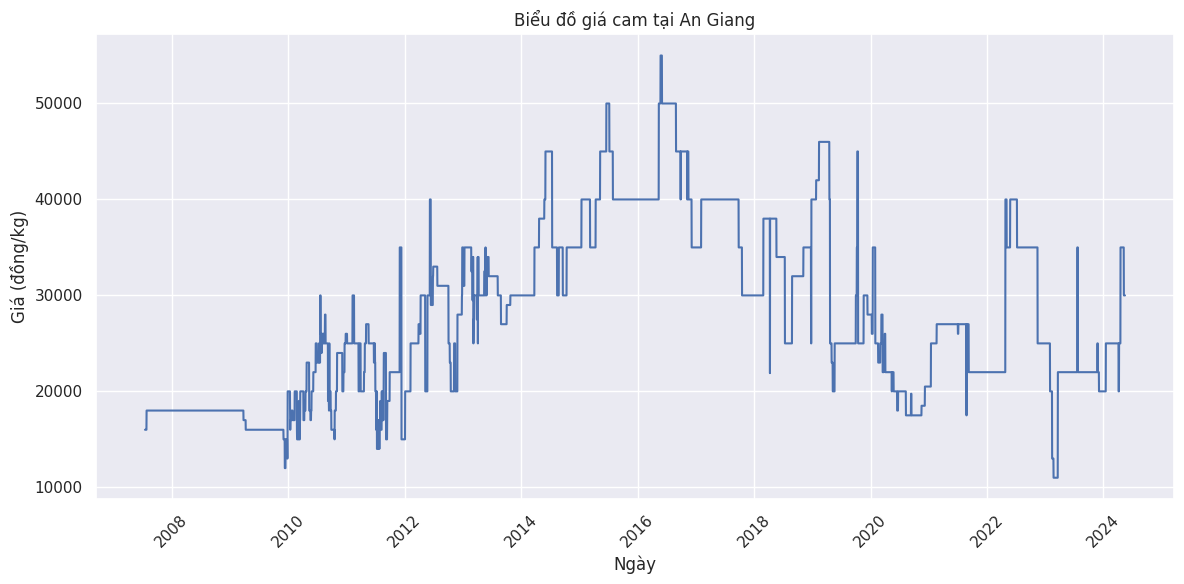

In [6]:
sns.set(style="darkgrid")
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_orange, x=df_orange.index, y='price')
plt.title('Biểu đồ giá cam tại An Giang')
plt.xlabel('Ngày')
plt.ylabel('Giá (đồng/kg)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## GIÁ XĂNG

In [7]:
df_gasoline = pd.read_csv('https://raw.githubusercontent.com/thuongh2/FinalProject/main/data_final/Xang/gia_xang.csv', encoding='ISO-8859-1')
df_gasoline.tail()

,date,RON 95-III
170,2/5/2024,24.95
171,9/5/2024,23.54
172,16/05/2024,23.13
173,23/05/2024,23.21
174,29/05/2024,23.21


### Xử lý outlier

<Axes: >

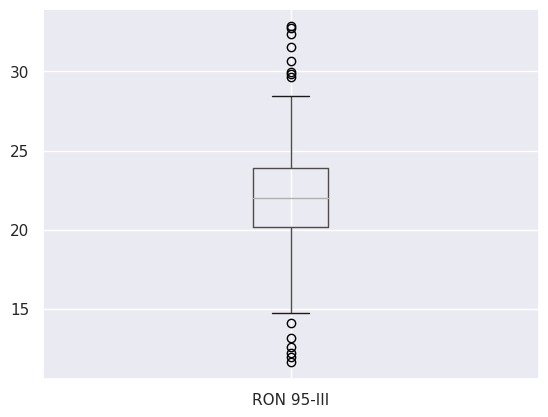

In [8]:
df_gasoline[['RON 95-III']].boxplot()

In [9]:
# Tính toán ngưỡng cho outlier sử dụng IQR
Q1 = df_gasoline['RON 95-III'].quantile(0.25)
Q3 = df_gasoline['RON 95-III'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

In [10]:
# Xác định các dòng dữ liệu có giá trị nằm ngoài ngưỡng
outliers = df_gasoline[(df_gasoline['RON 95-III'] < lower_bound) | (df_gasoline['RON 95-III'] > upper_bound)]
print("Số lượng outlier:", len(outliers))

Số lượng outlier: 14


In [11]:
# Kiểm tra và thay đổi giá trị nếu nó nằm ngoài ngưỡng
df_gasoline.at[df_gasoline.index[0], 'RON 95-III'] = min(max(df_gasoline.iloc[0]['RON 95-III'], lower_bound), upper_bound)

# Thay thế giá trị của outlier bằng giá trị trước đó
for index, row in outliers.iterrows():
    previous_date_index = df_gasoline.index.get_loc(index) - 1
    if previous_date_index >= 0:
        previous_date = df_gasoline.index[previous_date_index]
        previous_value = df_gasoline.loc[previous_date, 'RON 95-III']
        df_gasoline.at[index, 'RON 95-III'] = previous_value

<Axes: >

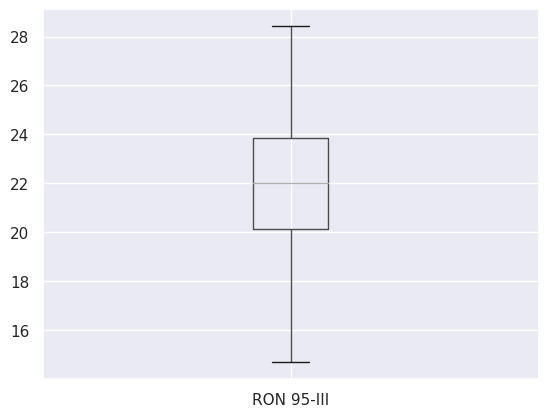

In [12]:
df_gasoline[['RON 95-III']].boxplot()

### Fill dữ liệu ngày bị thiếu

In [13]:
df_gasoline['date'] = pd.to_datetime(df_gasoline['date'])
df_gasoline.set_index('date', inplace=True)

<ipython-input-13-2ca4586e2886>:1: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df_gasoline['date'] = pd.to_datetime(df_gasoline['date'])


In [14]:
idx = pd.date_range(df_gasoline.index.min(), df_gasoline.index.max())
df_gasoline = df_gasoline.reindex(idx)
df_gasoline.fillna(method='ffill', inplace=True)

### Merge dữ liệu xăng với cam

In [15]:
start_date = df_gasoline.index.min()
df_orange_filtered = df_orange.loc[start_date:]

df_merged_gasoline = pd.merge(df_orange_filtered, df_gasoline[['RON 95-III']], left_index=True, right_index=True, how='left')
df_merged_gasoline['RON 95-III'] = df_merged_gasoline['RON 95-III'].ffill()

print(df_merged_gasoline.tail())

            price  RON 95-III
2024-05-11  30000       23.54
2024-05-12  30000       23.54
2024-05-13  30000       23.54
2024-05-14  30000       23.54
2024-05-15  30000       23.54


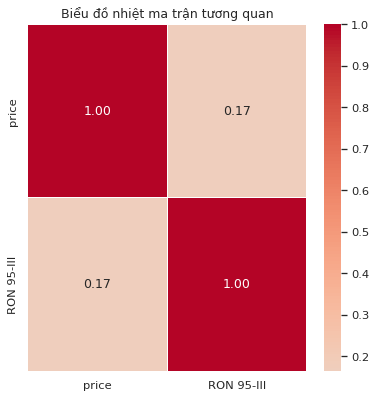

In [16]:
correlation_matrix = df_merged_gasoline.corr()

plt.figure(figsize=(6, 6), dpi=75)
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", linewidths=.5, cmap='coolwarm', center=0)
plt.title('Biểu đồ nhiệt ma trận tương quan')
plt.show()

In [17]:
# df_merged_gasoline.to_csv('coffee_gasoline.csv', index=True)

### Làm mịn dữ liệu

In [18]:
df_merged_gasoline = df_merged_gasoline.rolling(window=30, min_periods=1).mean()

# Mô hình dự đoán

## Giá cà phê kết hợp giá xăng

### Xây dựng mô hình

In [19]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:(i + seq_length), :])
        y.append(data[i + seq_length, 0])
    return np.array(X), np.array(y)

def calculate_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [20]:
# Preprocess data
scaler_price = MinMaxScaler(feature_range=(0, 1))
scaled_price = scaler_price.fit_transform(df_merged_gasoline[['price']])

scaler_export = MinMaxScaler(feature_range=(0, 1))
scaled_export = scaler_export.fit_transform(df_merged_gasoline[['RON 95-III']])

scaled_data = np.concatenate((scaled_price, scaled_export), axis=1)

In [21]:
seq_length = 30
X, y = create_sequences(scaled_data, seq_length)

In [22]:
X.shape, y.shape

((2064, 30, 2), (2064,))

In [23]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print("Kích thước tập huấn luyện:", X_train.shape, y_train.shape)
print("Kích thước tập kiểm tra:", X_test.shape, y_test.shape)

Kích thước tập huấn luyện: (1651, 30, 2) (1651,)
Kích thước tập kiểm tra: (413, 30, 2) (413,)


In [24]:
model_gasoline = Sequential()
# model_gasoline.add(GRU(units=128, return_sequences=True, input_shape=(seq_length, 2)))
model_gasoline.add(GRU(units=128, input_shape=(seq_length, 2)))
model_gasoline.add(Dropout(0.2))
model_gasoline.add(Dense(units=1))

In [25]:
model_gasoline.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

In [26]:
model_gasoline.fit(X_train, y_train, epochs=50, batch_size=64, callbacks=[early_stopping])

Epoch 1/50
26/26 [==============================] - 15s 99ms/step - loss: 0.0395
Epoch 2/50
26/26 [==============================] - 2s 85ms/step - loss: 0.0048
Epoch 3/50
26/26 [==============================] - 1s 46ms/step - loss: 0.0021
Epoch 4/50
26/26 [==============================] - 1s 42ms/step - loss: 0.0017
Epoch 5/50
26/26 [==============================] - 2s 64ms/step - loss: 0.0015
Epoch 6/50
26/26 [==============================] - 2s 70ms/step - loss: 0.0015
Epoch 7/50
26/26 [==============================] - 1s 56ms/step - loss: 0.0014
Epoch 8/50
26/26 [==============================] - 1s 39ms/step - loss: 0.0013
Epoch 9/50
26/26 [==============================] - 1s 41ms/step - loss: 0.0011
Epoch 10/50
26/26 [==============================] - 1s 39ms/step - loss: 0.0011
Epoch 11/50
26/26 [==============================] - 1s 40ms/step - loss: 0.0011
Epoch 12/50
26/26 [==============================] - 1s 39ms/step - loss: 9.8609e-04
Epoch 13/50
26/26 [=============

### Dự đoán trên tập train

In [27]:
train_predictions = model_gasoline.predict(X_train)

52/52 [==============================] - 1s 9ms/step


In [28]:
train_predictions = scaler_price.inverse_transform(train_predictions)
y_train = scaler_price.inverse_transform(y_train.reshape(-1, 1))

In [29]:
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
train_mape = calculate_mape(y_train, train_predictions)

print(f'Training RMSE: {train_rmse:.2f}')
print(f'Training MAPE: {train_mape:.2f}%')

Training RMSE: 245.40
Training MAPE: 0.71%


In [30]:
dates = df_merged_gasoline.index.tolist()

fig = go.Figure()

fig.add_trace(go.Scatter(x=dates[:len(y_train)], y=y_train.flatten(), mode='lines', name='Giá thực tế', line=dict(width=2)))
fig.add_trace(go.Scatter(x=dates[:len(train_predictions)], y=train_predictions.flatten(), mode='lines', name='Giá dự đoán', line=dict(color='orange', width=2)))

fig.update_layout(
    title={
        'text': 'Biểu đồ dự đoán giá cam trên tập huấn luyện (mô hình GRU, dữ liệu giá cam và giá xăng)',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    xaxis_title='Ngày',
    yaxis_title='Giá (đồng/kg)',
    xaxis_tickangle=45,
    width=1200,
    height=600
)

fig.show()

### Dự đoán trên tập test

In [31]:
test_predictions = model_gasoline.predict(X_test)

13/13 [==============================] - 0s 9ms/step


In [32]:
test_predictions = scaler_price.inverse_transform(test_predictions)
y_test = scaler_price.inverse_transform(y_test.reshape(-1, 1))

In [33]:
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
test_mape = calculate_mape(y_test, test_predictions)

print(f'Testing RMSE: {test_rmse:.2f}')
print(f'Testing MAPE: {test_mape:.2f}%')

Testing RMSE: 234.20
Testing MAPE: 0.92%


In [34]:
dates = df_merged_gasoline.index.tolist()
test_dates = dates[-len(y_test):]

fig = go.Figure()
fig.add_trace(go.Scatter(x=test_dates, y=y_test.flatten(), mode='lines', name='Giá thực tế', line=dict(width=2)))
fig.add_trace(go.Scatter(x=test_dates, y=test_predictions.flatten(), mode='lines', name='Giá dự đoán', line=dict(color='orange', width=2)))

fig.update_layout(
    title={
        'text': 'Biểu đồ dự đoán giá xăng trên tập kiểm tra (mô hình GRU, dữ liệu giá cam và giá xăng)',
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'
    },
    xaxis_title='Ngày',
    yaxis_title='Giá (đồng/kg)',
    xaxis_tickangle=45,
    width=1200,
    height=600
)

fig.show()

### Đánh giá kết quả

In [35]:
results = pd.DataFrame({
    '': ['Train', 'Test'],
    'RMSE': [train_rmse, test_rmse],
    'MAPE (%)': [train_mape, test_mape]
})
results = results.round(2)

print(results)

           RMSE  MAPE (%)
0  Train  245.4      0.71
1   Test  234.2      0.92


### Lưu mô hình

In [36]:
# model_gasoline.save('GRU_gia_cam_xang.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

